In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
df = pd.read_excel('/content/shkol2.xlsx',header = None).drop([2,3],axis = 0).transpose().dropna()
df

,0,1
0,9131.0,1.0
1,7955.0,69.0
2,8990.0,99.0
3,8888.0,102.0
4,9471.0,136.0
...,...,...
177,2231000.0,3692.0
178,2261900.0,3695.0
179,2196790.0,3697.0
180,2316800.0,3703.0


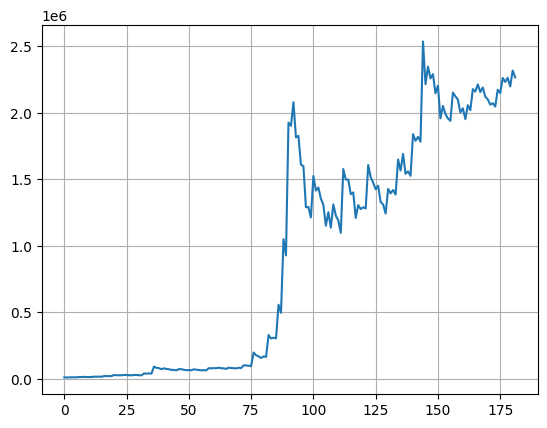

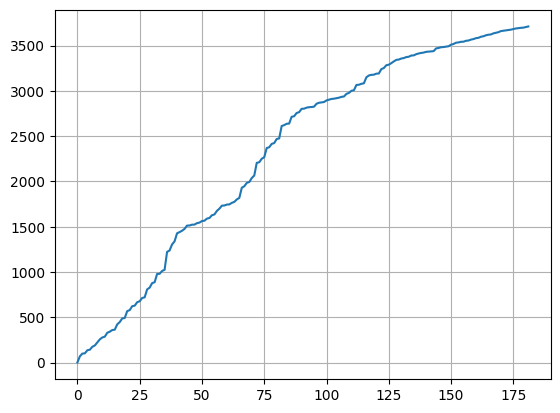

In [3]:
df[0].plot(kind = 'line')
plt.grid()
plt.show()
print('')
df[1].plot(kind = 'line')
plt.grid()

In [4]:
normalizer = MinMaxScaler()
normalizer.fit(df[:-10])
df_norm = pd.DataFrame(normalizer.transform(df))
df_norm.describe()

,0,1
count,182.000000,182.000000
mean,0.365995,0.640959
std,0.347279,0.316259
min,0.000000,0.000000
25%,0.022671,0.413504
50%,0.438254,0.764883
75%,0.703764,0.928386
max,1.000000,1.012835


In [5]:
def preperation(dataset , seq_len , horizon = 1 , final_prediction = False):
  sample_number = len(dataset)-seq_len-horizon+1
  x = np.zeros((sample_number , seq_len,2))
  y = np.zeros((sample_number , horizon,2))
  if not final_prediction:
    for i in range(sample_number):
      x[i,:,:] = dataset[i:i+seq_len]
      y[i,:,:] = dataset[i+seq_len:i+seq_len+horizon]
    return  x , y
  else:
    sample = len(dataset)-seq_len
    x = np.zeros((sample_number+1 , seq_len,2))
    for i in range(sample_number+1):
     x[i,:,:] = dataset[i:i+seq_len]
    return x


for i in range(1,5):
  globals()[f'x{4*i}_train'] , globals()[f'y{4*i}_train'] = preperation(df_norm , seq_len = 4*i , horizon = 4)
  print(f'for step length {4*i} input has shape of :{globals()[f"x{4*i}_train"].shape} , and target has shape of\
  {globals()[f"y{4*i}_train"].shape}')


for step length 4 input has shape of :(175, 4, 2) , and target has shape of  (175, 4, 2)
for step length 8 input has shape of :(171, 8, 2) , and target has shape of  (171, 4, 2)
for step length 12 input has shape of :(167, 12, 2) , and target has shape of  (167, 4, 2)
for step length 16 input has shape of :(163, 16, 2) , and target has shape of  (163, 4, 2)


In [6]:
## deviding train datas into train and validation set to select best structure and tune hyper parameters
## like step length
from sklearn.model_selection import train_test_split
for i in range(1,5):
  globals()[f'x{4*i}_train'] ,globals()[f'x{4*i}_test'] , globals()[f'y{4*i}_train'], globals()[f'y{4*i}_test'] = \
  train_test_split( globals()[f'x{4*i}_train'], globals()[f'y{4*i}_train'], test_size = 0.1 , shuffle = False)
  globals()[f'x{4*i}_train'] ,globals()[f'x{4*i}_val'] , globals()[f'y{4*i}_train'], globals()[f'y{4*i}_val'] = \
  train_test_split( globals()[f'x{4*i}_train'], globals()[f'y{4*i}_train'], test_size = 0.1 , shuffle = False)
  print(f'for step length {4*i} train input has shape of :{globals()[f"x{4*i}_train"].shape} , and train target has shape of\
  {globals()[f"y{4*i}_train"].shape}\n and validation input has shape :{globals()[f"x{4*i}_val"].shape} and validation target\
  {globals()[f"y{4*i}_val"].shape} and test input has shape :{globals()[f"x{4*i}_test"].shape} with test target shape :{globals()[f"x{4*i}_test"].shape}\n')

for step length 4 train input has shape of :(141, 4, 2) , and train target has shape of  (141, 4, 2)
 and validation input has shape :(16, 4, 2) and validation target  (16, 4, 2) and test input has shape :(18, 4, 2) with test target shape :(18, 4, 2)

for step length 8 train input has shape of :(137, 8, 2) , and train target has shape of  (137, 4, 2)
 and validation input has shape :(16, 8, 2) and validation target  (16, 4, 2) and test input has shape :(18, 8, 2) with test target shape :(18, 8, 2)

for step length 12 train input has shape of :(135, 12, 2) , and train target has shape of  (135, 4, 2)
 and validation input has shape :(15, 12, 2) and validation target  (15, 4, 2) and test input has shape :(17, 12, 2) with test target shape :(17, 12, 2)

for step length 16 train input has shape of :(131, 16, 2) , and train target has shape of  (131, 4, 2)
 and validation input has shape :(15, 16, 2) and validation target  (15, 4, 2) and test input has shape :(17, 16, 2) with test target sh

finding best model length

In [7]:
from keras.models import Model
from keras.layers import Input,SimpleRNN,LSTM,GRU,Dense , Reshape

In [8]:
def model_maker(layer):
  ## try to find best model with 12 step length
  input = Input((12,2))
  layer1 = layer(units = 50 , return_sequences = True)(input)
  layer2 = layer(units = 40 , return_sequences = False)(layer1)
  dense = Dense(8)(layer2)
  output = Reshape((4,2))(dense)
  model = Model(inputs = input , outputs = output)
  model.compile(optimizer = 'adam' , loss= keras.losses.mae)
  model.summary()
  print('\n'*2)
  return model

model_rnn = model_maker(SimpleRNN)
model_gru = model_maker(GRU)
model_lstm = model_maker(LSTM)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 2)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 12, 50)            2650      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3640      
                                                                 
 dense (Dense)               (None, 8)                 328       
                                                                 
 reshape (Reshape)           (None, 4, 2)              0         
                                                                 
Total params: 6618 (25.85 KB)
Trainable params: 6618 (25.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model: "model_1"
_______

In [9]:
model_rnn.fit(x12_train,y12_train, validation_data = (x12_val,y12_val),epochs = 30)
model_gru.fit(x12_train,y12_train, validation_data = (x12_val,y12_val),epochs = 30)
model_lstm.fit(x12_train,y12_train, validation_data = (x12_val,y12_val),epochs = 30)

Epoch 1/30
5/5 [==============================] - 4s 113ms/step - loss: 0.4093 - val_loss: 0.4257
Epoch 2/30
5/5 [==============================] - 0s 16ms/step - loss: 0.1802 - val_loss: 0.2096
Epoch 3/30
5/5 [==============================] - 0s 14ms/step - loss: 0.1119 - val_loss: 0.1132
Epoch 4/30
5/5 [==============================] - 0s 14ms/step - loss: 0.0870 - val_loss: 0.0940
Epoch 5/30
5/5 [==============================] - 0s 14ms/step - loss: 0.0751 - val_loss: 0.0664
Epoch 6/30
5/5 [==============================] - 0s 13ms/step - loss: 0.0704 - val_loss: 0.0588
Epoch 7/30
5/5 [==============================] - 0s 14ms/step - loss: 0.0630 - val_loss: 0.0666
Epoch 8/30
5/5 [==============================] - 0s 14ms/step - loss: 0.0591 - val_loss: 0.0676
Epoch 9/30
5/5 [==============================] - 0s 14ms/step - loss: 0.0584 - val_loss: 0.0602
Epoch 10/30
5/5 [==============================] - 0s 13ms/step - loss: 0.0560 - val_loss: 0.0669
Epoch 11/30
5/5 [===========

In [10]:
print(f'our validation loss with simple rnn is {model_rnn.evaluate(x12_val,y12_val)} \
and for gru is {model_gru.evaluate(x12_val,y12_val)}\nand for lstm is {model_lstm.evaluate(x12_val,y12_val)}')

1/1 [==============================] - 0s 25ms/step - loss: 0.0401
our validation loss with simple rnn is 0.06411249190568924 and for gru is 0.025446295738220215
and for lstm is 0.040125660598278046


so the best structure is lstm we proceed with lstm and go forward to find best step length

In [34]:
model_list = []
for i in range(1,5):
  input = Input((4*i,2))
  layer1 = GRU(units = 50 , return_sequences = True)(input)
  layer2 = GRU(units = 40 , return_sequences = False)(layer1)
  dense = Dense(8)(layer2)
  output = Reshape((4,2))(dense)
  model = Model(inputs = input , outputs = output)
  model.compile(optimizer = 'adam' , loss= keras.losses.mae)
  model.summary()
  x , x_val , y , y_val = globals()[f'x{4*i}_train'] ,globals()[f'x{4*i}_val'] , globals()[f'y{4*i}_train'], globals()[f'y{4*i}_val']
  model.fit(x , y , validation_data = (x_val,y_val), epochs = 30)
  model_list.append(model)
  print('\n'*2)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 4, 2)]            0         
                                                                 
 gru_18 (GRU)                (None, 4, 50)             8100      
                                                                 
 gru_19 (GRU)                (None, 40)                11040     
                                                                 
 dense_11 (Dense)            (None, 8)                 328       
                                                                 
 reshape_11 (Reshape)        (None, 4, 2)              0         
                                                                 
Total params: 19468 (76.05 KB)
Trainable params: 19468 (76.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
5/5 [======

In [35]:
for i in range(1,5):
  x_val , y_val = globals()[f'x{4*i}_val'] , globals()[f'y{4*i}_val']
  print(f'for model with step length {4*i} our validation mae loss is {model_list[i-1].evaluate(x_val,y_val)}')

1/1 [==============================] - 0s 39ms/step - loss: 0.0362
for model with step length 4 our validation mae loss is 0.036164939403533936
1/1 [==============================] - 0s 35ms/step - loss: 0.0442
for model with step length 8 our validation mae loss is 0.04421897977590561
1/1 [==============================] - 0s 40ms/step - loss: 0.0287
for model with step length 12 our validation mae loss is 0.028735272586345673
1/1 [==============================] - 0s 42ms/step - loss: 0.0390
for model with step length 16 our validation mae loss is 0.038996580988168716


so we proceed with 12 step length to predict 4 step ahead

In [42]:
final_model = model_list[2]
y_hat_train = final_model.predict(x12_train)
y_hat_validation = final_model.predict(x12_val)
y_hat_test = final_model.predict(x12_test)


1/1 [==============================] - 0s 34ms/step


defining horizon and prepare dataframe

In [43]:
def horizon_define(y_hat , horizon):
  y_final = np.zeros((len(y_hat),2))
  for i in range(len(y_hat)):
   y_final[i,:] = y_hat[i,horizon-1,:]
  y_final = normalizer.inverse_transform(pd.DataFrame(y_final))
  y_final = pd.DataFrame(y_final)
  return y_final

y1_hat_train = horizon_define(y_hat_train , horizon = 1)
y1_hat_validation = horizon_define(y_hat_validation , horizon = 1)
y1_hat_test = horizon_define(y_hat_test , horizon = 1)

y4_hat_train = horizon_define(y_hat_train , horizon = 4)
y4_hat_validation = horizon_define(y_hat_validation , horizon = 4)
y4_hat_test = horizon_define(y_hat_test , horizon = 4)

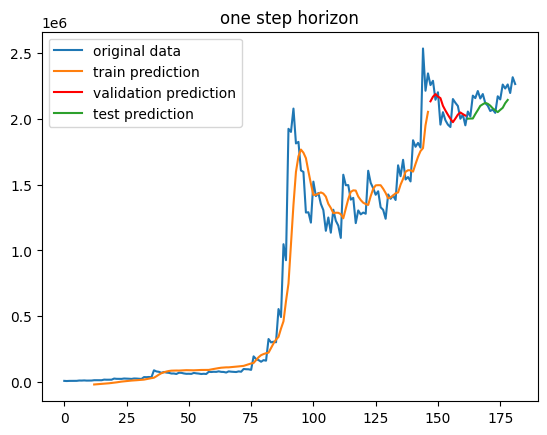

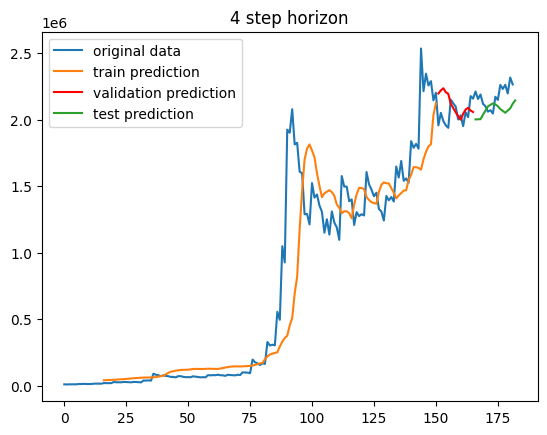

In [44]:
## one step predction
df[[0]].rename(columns = {0:'original data'}).plot(kind = 'line',label = 'original data')
plt.plot(range(12,len(y1_hat_train)+12),y1_hat_train[[0]] , label = 'train prediction')
plt.plot(range(len(y1_hat_train)+12,len(y1_hat_train)+12+len(y1_hat_validation)),y1_hat_validation[[0]] ,color = 'red', label = 'validation prediction')
plt.plot(range(len(y1_hat_train)+12+len(y1_hat_validation),len(y1_hat_train)+12+len(y1_hat_validation)+len(y1_hat_test)),y1_hat_test[[0]] , label = 'test prediction')
plt.legend()
plt.title('one step horizon')
plt.show()

## 4 step prediction
print('\n'*2)
df[[0]].rename(columns = {0:'original data'}).plot(kind = 'line',label = 'original data')
plt.plot(range(12+4,len(y1_hat_train)+12+4),y4_hat_train[[0]] , label = 'train prediction')
plt.plot(range(len(y1_hat_train)+12+4,len(y1_hat_train)+12+4+len(y1_hat_validation)),y4_hat_validation[[0]] ,color = 'red', label = 'validation prediction')
plt.plot(range(len(y1_hat_train)+12+4+len(y1_hat_validation),len(y1_hat_train)+12+4+len(y4_hat_validation)+len(y1_hat_test)),y1_hat_test[[0]] , label = 'test prediction')
plt.legend()
plt.title('4 step horizon')
plt.show()

determine mean absolute error for test prediction

In [49]:
from sklearn.metrics import mean_absolute_error
test_mae01 = mean_absolute_error(y1_hat_test[0],df[[0]][-17-3:-3])
test_mae04 = mean_absolute_error(y4_hat_test[0],df[[0]][-17:])
test_mae11 = mean_absolute_error(y4_hat_test[1],df[[1]][-17-3:-3])
test_mae14 = mean_absolute_error(y4_hat_test[1],df[[1]][-17:])
print(f'for 1 step ahead horizon our mae is for first column is {test_mae01} and for 4 step ahead is {test_mae04}\n\
and for second column in one step ahead is {test_mae11} and for 4 step ahead is {test_mae14}')

for 1 step ahead horizon our mae is for first column is 78508.42122821255 and for 4 step ahead is 100421.30909465348
and for second column in one step ahead is 58.08698416457411 and for 4 step ahead is 75.61639592927999


In [53]:
final_x = preperation(df_norm[-12:] , seq_len =12 , final_prediction = True)
predicted_y = model_list[2].predict(final_x)
predicted_y = pd.DataFrame(predicted_y[0])
predicted_y = pd.DataFrame(normalizer.inverse_transform(predicted_y))
predicted_y

1/1 [==============================] - 0s 29ms/step


,0,1
0,2197233.25,3612.332275
1,2255456.00,3614.515381
2,2195580.00,3620.818359
3,2241923.00,3629.595947


In [54]:
final_y = pd.concat([df,predicted_y]).reset_index().drop(['index'],axis = 1)
final_y.transpose()
final_y.to_csv('final_output2.csv')